Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

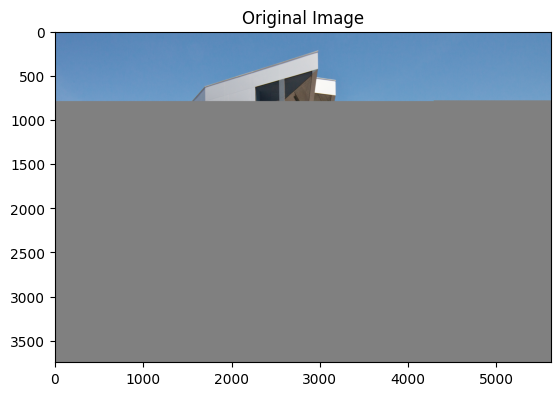

In [4]:
img = cv2.imread("/content/jcsmr.jpg")

if img is None:
    print("Error: Image not found or could not be loaded.")
else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Original Image")
    plt.show()

Downsampling

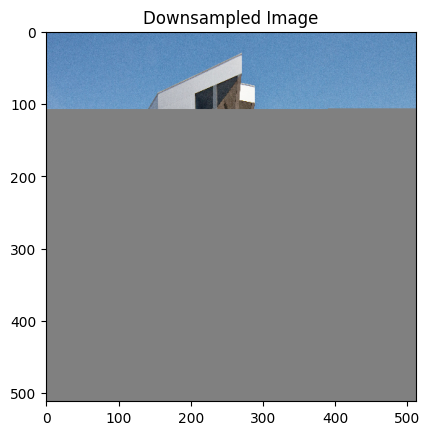

In [5]:
#d_img = cv2.resize(img, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
d_img = cv2.resize(img, (512, 512))  # Ignores aspect ratio
plt.imshow(d_img)
plt.title("Downsampled Image")
plt.show()

Augmentation Pipeline

In [6]:
os.makedirs("augmented_dataset", exist_ok=True)

In [ ]:
#Simple
'''transform = A.Compose([
    A.RandomRotate90( p = 0.6),                     # 90° rotations
    A.Rotate(limit=45, p=0.4),              # Random rotation (-45° to +45°)
    A.HorizontalFlip(p=0.5),                # Flip left-right
    A.VerticalFlip(p=0.3),                  # Flip up-down (30% chance)
    A.RandomBrightnessContrast(p=0.5),      # Adjust brightness/contrast
    A.GaussianBlur(blur_limit=(3, 7), p = 0.4),       # Mild blur
    A.AutoContrast( p = 0.3),                 # Contrast
    A.ColorJitter(p=0.3),                   # Color jitter
    A.RandomGamma(p=0.3),                   # Gamma correction
    A.CLAHE(p=0.2),                         # Contrast enhancement
    A.RandomResizedCrop((224,224),p =0.7),  # Crop & resize
    A.Resize(224,224)
])'''


In [7]:

transform = A.Compose([
    # Geometric Transformations (increased intensity and variety)
    A.RandomRotate90(p=0.8),  # Increased probability for 90° rotations
    A.Rotate(limit=60, p=0.6),  # Wider rotation range (-60° to +60°)
    A.HorizontalFlip(p=0.7),  # Increased probability for left-right flip
    A.VerticalFlip(p=0.5),  # Increased probability for up-down flip
    #A.RandomResizedCrop(height=224, width=224, scale=(0.5, 1.0), ratio=(0.75, 1.33), p=0.8),  # More aggressive cropping
    A.RandomResizedCrop((224,224),p =0.8),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, p=0.7),  # Shift, scale, and rotate combined
    A.Perspective(scale=(0.05, 0.1), p=0.5),  # Simulate 3D perspective distortions
    A.Affine(shear=(-20, 20), p=0.5),  # Add shear transformations

    # Color and Lighting Transformations (increased intensity)
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.7),  # Stronger brightness/contrast
    A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2, p=0.7),  # More intense color jitter
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),  # Wider gamma range
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),  # Stronger contrast enhancement
    A.HueSaturationValue(hue_shift_limit=30, sat_shift_limit=40, val_shift_limit=30, p=0.6),  # Additional color shifts
    A.Solarize(threshold=128, p=0.3),  # Invert pixels above threshold for dramatic effect
    A.Posterize(p=0.3),  # Reduce color depth for stylistic variation

    # Noise and Texture Transformations (new additions)
    A.GaussianBlur(blur_limit=(3, 9), p=0.5),  # Wider blur range
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),  # Gaussian noise
    A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.3),  # Fixed: color_shift as tuple
    A.MultiplicativeNoise(multiplier=(0.9, 1.1), elementwise=True, p=0.3),  # Per-pixel noise
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.3),

    # Occlusion and Dropout (new additions)
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),  # Random rectangular dropouts
    A.GridDropout(ratio=0.3, p=0.3),  # Drop grid-like patches
    A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.5, alpha_coef=0.08, p=0.3),  # Simulate fog
    A.RandomRain(slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, blur_value=7, p=0.3),  # Simulate rain

    # Final Resize (unchanged)
    A.Resize(224, 224, always_apply=True),  # Ensure consistent output size
], p=1.0)  # Ensure at least some augmentations are applied

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-675164280.py:19: UserWarning: Argument(s) 'threshold' are not valid for transform Solarize
  A.Solarize(threshold=128, p=0.3),  # Invert pixels above threshold for dramatic effect
/tmp/ipython-input-675164280.py:24: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),  # Gaussian noise
/tmp/ipython-input-675164280.py:30: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),  # Random rectangular dropouts
/tmp/ipython-input-675164280.py:32: UserWarning: Argument(s) 'fog_coef_lower, fog_coef_upper' are not valid for transform RandomFog
  A.RandomFog(fog_coef_lower

In [8]:
# Generate 1000 augmented images
stime = time.time()
N = 500  #tried 1000
for i in tqdm(range(N)):
    augmented = transform(image=d_img)  # Apply augmentations
    augmented_img = augmented["image"]

    # Save as JPEG (adjust quality if needed)
    cv2.imwrite(
        f"augmented_dataset/aug_{i}.jpg",
        cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR),  # Convert back to BGR
        [int(cv2.IMWRITE_JPEG_QUALITY), 90]  # 90% quality
    )
print(f"Elapsed time: {time.time()-stime} seconds")

100%|██████████| 500/500 [00:20<00:00, 24.55it/s]

Elapsed time: 20.374261617660522 seconds


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Hyperparameters

In [ ]:
BATCH_SIZE = 32
EPOCHS = 60
LEARNING_RATE = 1e-3
TEMPERATURE = 0.07
EMBEDDING_DIM = 128

Contrastive Dataset

In [ ]:

class ContrastiveDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                          if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            # Apply two different augmentations to create positive pair
            x1 = self.transform(image)
            x2 = self.transform(image)

        return x1, x2

In [ ]:

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p = 0.2),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = ContrastiveDataset("/content/augmented_dataset", transform=train_transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers= 2, persistent_workers=True)

In [ ]:
class ContrastiveModel(nn.Module):
    def __init__(self, base_model, embedding_dim=128):
        super(ContrastiveModel, self).__init__()
        self.encoder = base_model
        self.projection_head = nn.Sequential(
            nn.Linear(1000, 512),  # ResNet outputs 1000-dim features
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return F.normalize(projections, p=2, dim=1)


In [ ]:
base_resnet = models.resnet18(pretrained=False)  # Or resnet34, resnet50
model = ContrastiveModel(base_resnet).to(device)
#model = ContrastiveModel(SlimResNet12().to(device)).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loss function

In [ ]:
def contrastive_loss(projections):
    batch_size = projections.shape[0] // 2
    temperature = TEMPERATURE

    # Split projections into original and augmented
    z1, z2 = torch.split(projections, batch_size)
    projections = torch.cat([z1, z2], dim=0)

    # Compute similarity matrix
    sim_matrix = torch.matmul(projections, projections.T) / temperature

    # Create labels for positive pairs
    labels = torch.arange(batch_size, device=device)
    labels = torch.cat([labels + batch_size, labels])

    # Cross-entropy loss
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

Optimiser

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Training

In [ ]:
def train():
    model.train()
    total_loss = 0

    for (x1, x2) in tqdm(dataloader, desc="Training"):
        x1 = x1.to(device)
        x2 = x2.to(device)

        # Forward pass
        p1 = model(x1)
        p2 = model(x2)
        projections = torch.cat([p1, p2], dim=0)

        # Compute loss
        loss = contrastive_loss(projections)
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

Training: 100%|██████████| 16/16 [00:42<00:00,  2.63s/it]


Epoch [1/60], Loss: 3.9688, time taken: 42.116106271743774 secs


Training: 100%|██████████| 16/16 [00:41<00:00,  2.58s/it]


Epoch [2/60], Loss: 3.5579, time taken: 41.31367230415344 secs


Training: 100%|██████████| 16/16 [00:41<00:00,  2.59s/it]


Epoch [3/60], Loss: 3.5213, time taken: 41.409682512283325 secs


Training: 100%|██████████| 16/16 [00:40<00:00,  2.52s/it]


Epoch [4/60], Loss: 3.4798, time taken: 40.31969380378723 secs


Training: 100%|██████████| 16/16 [00:40<00:00,  2.52s/it]


Epoch [5/60], Loss: 3.4122, time taken: 40.288055181503296 secs


Training: 100%|██████████| 16/16 [00:41<00:00,  2.62s/it]


Epoch [6/60], Loss: 3.4954, time taken: 41.93301343917847 secs


Training: 100%|██████████| 16/16 [00:39<00:00,  2.44s/it]


Epoch [7/60], Loss: 3.3702, time taken: 39.02981662750244 secs


Training: 100%|██████████| 16/16 [00:41<00:00,  2.59s/it]


Epoch [8/60], Loss: 3.2760, time taken: 41.5202796459198 secs


Training: 100%|██████████| 16/16 [00:47<00:00,  2.99s/it]


Epoch [9/60], Loss: 3.2517, time taken: 47.80177640914917 secs


Training: 100%|██████████| 16/16 [00:39<00:00,  2.47s/it]


Epoch [10/60], Loss: 3.1325, time taken: 39.56321954727173 secs


Training: 100%|██████████| 16/16 [00:41<00:00,  2.58s/it]


Epoch [11/60], Loss: 3.1192, time taken: 41.24232292175293 secs


Training: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it]


Epoch [12/60], Loss: 3.2112, time taken: 40.194249868392944 secs


Training: 100%|██████████| 16/16 [00:40<00:00,  2.50s/it]


Epoch [13/60], Loss: 3.0083, time taken: 40.04064917564392 secs


Training: 100%|██████████| 16/16 [00:41<00:00,  2.60s/it]


Epoch [14/60], Loss: 2.9232, time taken: 41.61345338821411 secs


Training: 100%|██████████| 16/16 [00:39<00:00,  2.50s/it]


Epoch [15/60], Loss: 2.9722, time taken: 39.94955539703369 secs


Training: 100%|██████████| 16/16 [00:40<00:00,  2.54s/it]


Epoch [16/60], Loss: 3.0508, time taken: 40.649436235427856 secs


Training: 100%|██████████| 16/16 [00:40<00:00,  2.56s/it]


Epoch [17/60], Loss: 3.0295, time taken: 40.96268081665039 secs


Training: 100%|██████████| 16/16 [00:41<00:00,  2.61s/it]


Epoch [18/60], Loss: 2.9282, time taken: 41.69472908973694 secs


Training: 100%|██████████| 16/16 [00:38<00:00,  2.42s/it]


Epoch [19/60], Loss: 2.9564, time taken: 38.76606559753418 secs


Training: 100%|██████████| 16/16 [00:39<00:00,  2.45s/it]


Epoch [20/60], Loss: 2.8050, time taken: 39.18279242515564 secs


Training: 100%|██████████| 16/16 [00:38<00:00,  2.39s/it]


Epoch [21/60], Loss: 2.8995, time taken: 38.277291774749756 secs


Training: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


Epoch [22/60], Loss: 2.8684, time taken: 43.58627462387085 secs


Training: 100%|██████████| 16/16 [00:41<00:00,  2.57s/it]


Epoch [23/60], Loss: 2.8216, time taken: 41.19856786727905 secs


Training: 100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


Epoch [24/60], Loss: 2.8814, time taken: 38.62379550933838 secs


Training: 100%|██████████| 16/16 [00:41<00:00,  2.59s/it]


Epoch [25/60], Loss: 2.9084, time taken: 41.444841384887695 secs


Training: 100%|██████████| 16/16 [00:38<00:00,  2.42s/it]


Epoch [26/60], Loss: 2.8346, time taken: 38.68089199066162 secs


Training: 100%|██████████| 16/16 [00:40<00:00,  2.56s/it]


Epoch [27/60], Loss: 2.7804, time taken: 40.91066074371338 secs


Training: 100%|██████████| 16/16 [00:39<00:00,  2.44s/it]


Epoch [28/60], Loss: 2.8084, time taken: 39.062246561050415 secs


Training: 100%|██████████| 16/16 [00:39<00:00,  2.48s/it]


Epoch [29/60], Loss: 2.7804, time taken: 39.677133560180664 secs


Training: 100%|██████████| 16/16 [00:39<00:00,  2.45s/it]


Epoch [30/60], Loss: 2.7832, time taken: 39.274906635284424 secs


Training: 100%|██████████| 16/16 [00:38<00:00,  2.43s/it]


Epoch [31/60], Loss: 2.7513, time taken: 38.81688117980957 secs


Training: 100%|██████████| 16/16 [00:41<00:00,  2.59s/it]


Epoch [32/60], Loss: 2.8547, time taken: 41.48231887817383 secs


Training: 100%|██████████| 16/16 [00:40<00:00,  2.50s/it]


Epoch [33/60], Loss: 2.6940, time taken: 40.036606311798096 secs


Training: 100%|██████████| 16/16 [00:39<00:00,  2.48s/it]


Epoch [34/60], Loss: 2.6575, time taken: 39.73303532600403 secs


Training: 100%|██████████| 16/16 [00:40<00:00,  2.50s/it]


Epoch [35/60], Loss: 2.7012, time taken: 40.039679527282715 secs


Training: 100%|██████████| 16/16 [00:40<00:00,  2.56s/it]


Epoch [36/60], Loss: 2.6483, time taken: 40.96365189552307 secs


Training: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it]


Epoch [37/60], Loss: 2.7387, time taken: 40.158435583114624 secs


Training: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it]


Epoch [38/60], Loss: 2.6527, time taken: 40.1539945602417 secs


Training: 100%|██████████| 16/16 [00:37<00:00,  2.36s/it]


Epoch [39/60], Loss: 2.6984, time taken: 37.78571271896362 secs


Training: 100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


Epoch [40/60], Loss: 2.6374, time taken: 38.55786848068237 secs


Training: 100%|██████████| 16/16 [00:38<00:00,  2.44s/it]


Epoch [41/60], Loss: 2.6531, time taken: 38.98945736885071 secs


Training: 100%|██████████| 16/16 [00:41<00:00,  2.58s/it]


Epoch [42/60], Loss: 2.5843, time taken: 41.276254177093506 secs


Training: 100%|██████████| 16/16 [00:39<00:00,  2.49s/it]


Epoch [43/60], Loss: 2.5923, time taken: 39.89330506324768 secs


Training: 100%|██████████| 16/16 [00:41<00:00,  2.56s/it]


Epoch [44/60], Loss: 2.5452, time taken: 41.010061502456665 secs


Training: 100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


Epoch [45/60], Loss: 2.5570, time taken: 38.3607280254364 secs


Training: 100%|██████████| 16/16 [00:40<00:00,  2.53s/it]


Epoch [46/60], Loss: 2.5499, time taken: 40.46871995925903 secs


Training: 100%|██████████| 16/16 [00:38<00:00,  2.39s/it]


Epoch [47/60], Loss: 2.5647, time taken: 38.18171143531799 secs


Training: 100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


Epoch [48/60], Loss: 2.6764, time taken: 38.37562441825867 secs


Training: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it]


Epoch [49/60], Loss: 2.7104, time taken: 37.911482095718384 secs


Training: 100%|██████████| 16/16 [00:42<00:00,  2.65s/it]


Epoch [50/60], Loss: 2.6122, time taken: 42.417447090148926 secs


Training: 100%|██████████| 16/16 [00:38<00:00,  2.42s/it]


Epoch [51/60], Loss: 2.5608, time taken: 38.65239858627319 secs


Training: 100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


Epoch [52/60], Loss: 2.5600, time taken: 38.52039551734924 secs


Training: 100%|██████████| 16/16 [00:38<00:00,  2.42s/it]


Epoch [53/60], Loss: 2.4220, time taken: 38.80253481864929 secs


Training: 100%|██████████| 16/16 [00:37<00:00,  2.34s/it]


Epoch [54/60], Loss: 2.4252, time taken: 37.479435205459595 secs


Training: 100%|██████████| 16/16 [00:38<00:00,  2.43s/it]


Epoch [55/60], Loss: 2.5394, time taken: 38.94957184791565 secs


Training: 100%|██████████| 16/16 [00:39<00:00,  2.45s/it]


Epoch [56/60], Loss: 2.4323, time taken: 39.26924443244934 secs


Training: 100%|██████████| 16/16 [00:39<00:00,  2.44s/it]


Epoch [57/60], Loss: 2.4503, time taken: 39.00521373748779 secs


Training: 100%|██████████| 16/16 [00:38<00:00,  2.44s/it]


Epoch [58/60], Loss: 2.4994, time taken: 38.97108054161072 secs


Training: 100%|██████████| 16/16 [00:41<00:00,  2.57s/it]


Epoch [59/60], Loss: 2.4471, time taken: 41.05968952178955 secs


Training: 100%|██████████| 16/16 [00:39<00:00,  2.45s/it]

Epoch [60/60], Loss: 2.4142, time taken: 39.279109954833984 secs


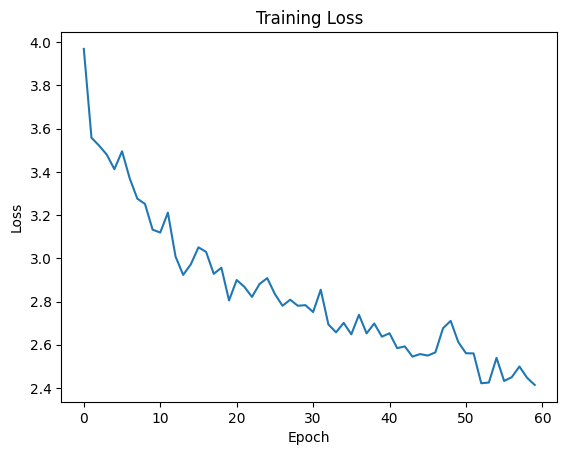

In [ ]:
# Training
loss_history = []
for epoch in range(EPOCHS):
    stime = time.time()
    epoch_loss = train()
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}, time taken: {time.time() - stime} secs")

# Plot training loss
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [ ]:
torch.save(model.encoder.state_dict(), '500img_60epoch_HA_encoder.pth')

In [ ]:
os.makedirs("folder2", exist_ok=True)

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
base_resnet = models.resnet18(pretrained=False)
model = ContrastiveModel(base_resnet).to(device)
#model = ContrastiveModel(base_model=base_resnet, embedding_dim=64).to(device)
#model.encoder.load_state_dict(torch.load('/content/500img_60epoch_HA_encoder.pth'), )
model.encoder.load_state_dict(torch.load('/content/500img_60epoch_HA_encoder.pth', map_location=torch.device('cpu')))
model.eval()

ContrastiveModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
query_image_path = '/content/school4.jpeg'  # Image A
comparison_folder = '/content/folder/'

In [ ]:
comparison_images = [os.path.join(comparison_folder, f) for f in os.listdir(comparison_folder)
                     if f.endswith(('.png', '.jpg', '.jpeg'))]


In [ ]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image)
    print(image.shape)
    return image.unsqueeze(0).to(device)  # Add batch dimension

# Function to extract embedding
def get_embedding(image_tensor, model):
    with torch.no_grad():
        embedding = model(image_tensor)
    return embedding.cpu().numpy()

torch.Size([3, 224, 224])


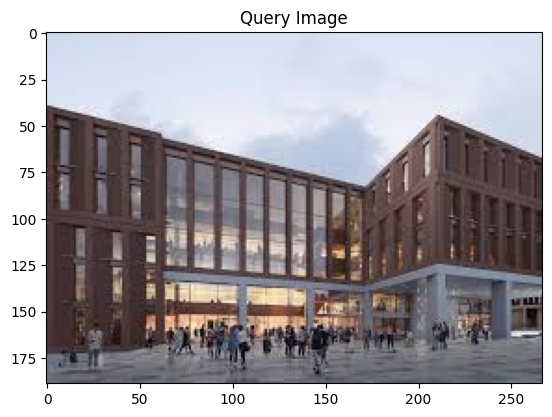

In [ ]:
query_image = load_image(query_image_path)
img = cv2.imread(query_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Query Image")
plt.show()

In [ ]:
query_embedding = get_embedding(query_image, model)

In [ ]:
print(f"Query embedding shape: {query_embedding.shape}")

Query embedding shape: (1, 128)


In [ ]:
embeddings = []
for img_path in comparison_images:
    image_tensor = load_image(img_path)
    embedding = get_embedding(image_tensor, model)
    embeddings.append(embedding)


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
embeddings = np.vstack(embeddings)  # Shape: (10, 64)
print(f"Embeddings shape: {embeddings.shape}")

Embeddings shape: (17, 128)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from scipy.spatial.distance import correlation

In [ ]:
def compute_similarity(embedding_a, embeddings, metric='euclidean'):
    if metric == 'cosine':
        scores = cosine_similarity(embedding_a, embeddings)[0]
        is_distance = False
    elif metric == 'euclidean':
        scores = euclidean_distances(embedding_a, embeddings)[0]
        is_distance = True
    elif metric == 'manhattan':
        scores = manhattan_distances(embedding_a, embeddings)[0]
        is_distance = True
    elif metric == 'dot':
        scores = np.dot(embedding_a, embeddings.T)[0]
        is_distance = False
    elif metric == 'correlation':
        scores = np.array([correlation(embedding_a[0], emb) for emb in embeddings])
        is_distance = True
    else:
        raise ValueError(f"Unsupported metric: {metric}")
    return scores, is_distance

In [ ]:
#similarities = cosine_similarity(query_embedding, embeddings)[0]  # Shape: (10,)

In [ ]:
similarity_metric = 'euclidean'
scores, is_distance = compute_similarity(query_embedding, embeddings, metric=similarity_metric)

In [ ]:
comparison_images

['/content/folder/o4.jpg',
 '/content/folder/traffic.jpg',
 '/content/folder/school3.jpeg',
 '/content/folder/munnar.jpg',
 '/content/folder/mountain.jpg',
 '/content/folder/bike.jpg',
 '/content/folder/school.jpeg',
 '/content/folder/o3.jpg',
 '/content/folder/moon.jpg',
 '/content/folder/library.jpg',
 '/content/folder/pc.jpg',
 '/content/folder/road.jpg',
 '/content/folder/tiger.jpg',
 '/content/folder/street.jpg',
 '/content/folder/Mo5.jpg',
 '/content/folder/o2.jpg',
 '/content/folder/school2.jpeg']

In [ ]:
print(scores)

[0.27374163 0.56648    0.24958365 0.6222236  0.52741784 0.54534245
 0.1986527  0.11065486 0.31540212 0.54994    0.21477355 0.37089974
 0.4666885  0.64524704 0.5607666  0.27297825 0.4012201 ]



Images in order of distance to Image A (metric: euclidean):
1. o3.jpg (Distance: 0.1107)
2. school.jpeg (Distance: 0.1987)
3. pc.jpg (Distance: 0.2148)
4. school3.jpeg (Distance: 0.2496)
5. o2.jpg (Distance: 0.2730)
6. o4.jpg (Distance: 0.2737)
7. moon.jpg (Distance: 0.3154)
8. road.jpg (Distance: 0.3709)
9. school2.jpeg (Distance: 0.4012)
10. tiger.jpg (Distance: 0.4667)
11. mountain.jpg (Distance: 0.5274)
12. bike.jpg (Distance: 0.5453)
13. library.jpg (Distance: 0.5499)
14. Mo5.jpg (Distance: 0.5608)
15. traffic.jpg (Distance: 0.5665)
16. munnar.jpg (Distance: 0.6222)
17. street.jpg (Distance: 0.6452)


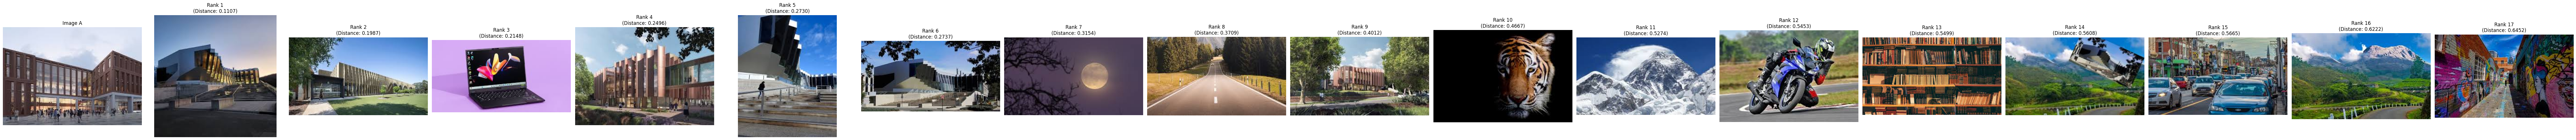

In [ ]:


# Assuming is_distance, scores, comparison_images, similarity_metric, query_image_path are defined
# Sort images by distance (ascending for distances, lower is better)
sorted_indices = np.argsort(scores)  # Ascending for distances
sort_label = 'Distance'

sorted_images = [comparison_images[i] for i in sorted_indices]
sorted_scores = scores[sorted_indices]

# Print images in order
print(f"\nImages in order of {sort_label.lower()} to Image A (metric: {similarity_metric}):")
for i, (img_path, score) in enumerate(zip(sorted_images, sorted_scores)):
    print(f"{i+1}. {os.path.basename(img_path)} ({sort_label}: {score:.4f})")

# Visualize all images in order of distance
num_images = len(sorted_images)
fig, axes = plt.subplots(1, num_images + 1, figsize=(5 * (num_images + 1), 5))  # +1 for Image A

# Plot Image A (query image)
image_a = Image.open(query_image_path).convert('RGB')
axes[0].imshow(image_a)
axes[0].set_title('Image A')
axes[0].axis('off')

# Plot sorted comparison images
for i, (img_path, score) in enumerate(zip(sorted_images, sorted_scores)):
    img = Image.open(img_path).convert('RGB')
    axes[i + 1].imshow(img)
    axes[i + 1].set_title(f'Rank {i + 1}\n({sort_label}: {score:.4f})')
    axes[i + 1].axis('off')

plt.tight_layout()
plt.savefig('sorted_images_by_distance.png')
plt.show()

In [ ]:

print(is_distance)

True



Images in order of distance to Image A (metric: euclidean):
1. o3.jpg (Distance: 0.2141)
2. pc.jpg (Distance: 0.2511)
3. moon.jpg (Distance: 0.3347)
4. o2.jpg (Distance: 0.3878)
5. o4.jpg (Distance: 0.4803)
6. road.jpg (Distance: 0.5032)
7. mountain.jpg (Distance: 0.5364)
8. munnar.jpg (Distance: 0.6400)
9. Mo5.jpg (Distance: 0.6571)
10. tiger.jpg (Distance: 0.7107)
11. bike.jpg (Distance: 0.7356)
12. traffic.jpg (Distance: 0.7365)
13. library.jpg (Distance: 0.7790)
14. street.jpg (Distance: 0.8186)


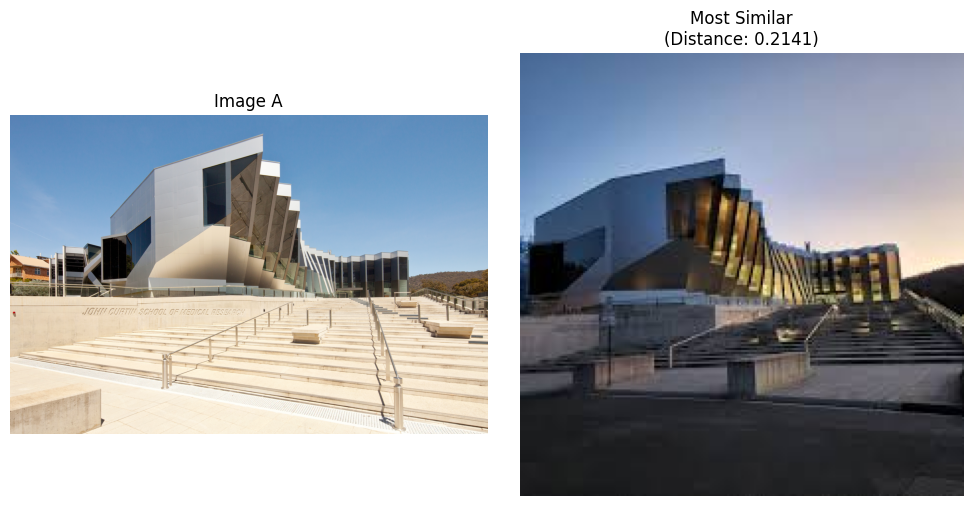

In [ ]:
if is_distance:
    sorted_indices = np.argsort(scores)  # Ascending for distances (lower is better)
    sort_label = 'Distance'
else:
    sorted_indices = np.argsort(scores)[::-1]  # Descending for similarities (higher is better)
    sort_label = 'Similarity'

sorted_images = [comparison_images[i] for i in sorted_indices]
sorted_scores = scores[sorted_indices]

# Print images in order
print(f"\nImages in order of {sort_label.lower()} to Image A (metric: {similarity_metric}):")
for i, (img_path, score) in enumerate(zip(sorted_images, sorted_scores)):
    print(f"{i+1}. {os.path.basename(img_path)} ({sort_label}: {score:.4f})")

# Get the most similar image
most_similar_path = sorted_images[0]
most_similar_score = sorted_scores[0]

# Visualize Image A and the most similar image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
image_a = Image.open(query_image_path).convert('RGB')
most_similar_image = Image.open(most_similar_path).convert('RGB')

ax1.imshow(image_a)
ax1.set_title('Image A')
ax1.axis('off')

ax2.imshow(most_similar_image)
ax2.set_title(f'Most Similar\n({sort_label}: {most_similar_score:.4f})')
ax2.axis('off')

plt.tight_layout()
#plt.savefig(output_image_path)
plt.show()